# Simple Bitcoin predictive Model

## Imports & API

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import requests 
import matplotlib as plt
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
#If you want to fetch the most recent bitcoin bpis, uncomment the next line
#If youre not connected to the internet, just use pd.read_csv

bit = pd.read_csv('./bit_bpi.csv',index_col=0)

#response = requests.get("https://api.coindesk.com/v1/bpi/historical/close.json?start=2010-09-01&end=2018-03-21")
try:
    bpi = response.json()['bpi']
    bit = pd.DataFrame.from_dict(bpi,orient='index')
    bit = bit.set_index(pd.to_datetime(bit.index))
    bit.columns = ['bpi']
    bit['diff'] = bit['bpi'].diff()
    bit.to_csv('bit_bpi.csv')
except:
    print('Didnt use requests')

In [22]:
reddit = pd.read_csv('./Reddit_Crypto.csv')

In [23]:
reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date']).dt.date

In [24]:
#I am only doing the number of comments per day in the cryt subreddit
reddit = pd.DataFrame(reddit.groupby('date')['comments'].sum())

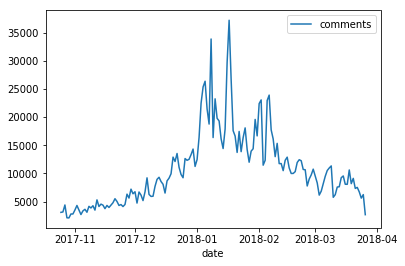

In [25]:
reddit.plot();

In [32]:
bit = bit.join(reddit)

## Preliminary EDA

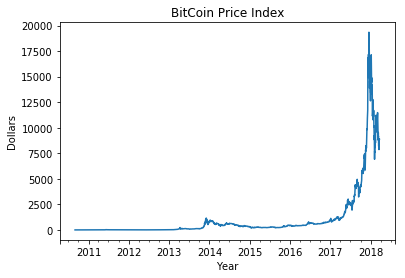

In [33]:
#
bit.bpi.plot()
plt.title('BitCoin Price Index')
plt.ylabel('Dollars')
plt.xlabel('Year');

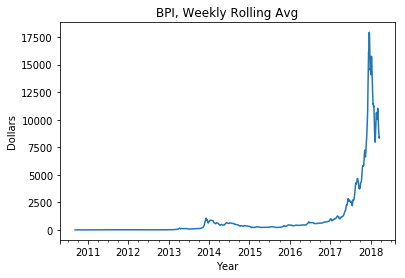

In [34]:
#weekly rolling avg by week
bit.bpi.rolling(window=7, center=False).mean().plot()
plt.title('BPI, Weekly Rolling Avg')
plt.ylabel('Dollars')
plt.xlabel('Year');

### Autocorrelation & Partial Autocorrelation

because of how correlated every day's bitcoin value is dependant on the day before,
we look at its autocorrelation.
    - (correlation, to itself)

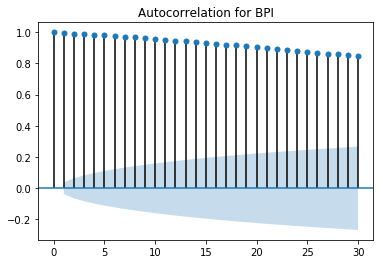

In [35]:
plot_acf(bit.bpi, lags=30)
plt.title('Autocorrelation for BPI');

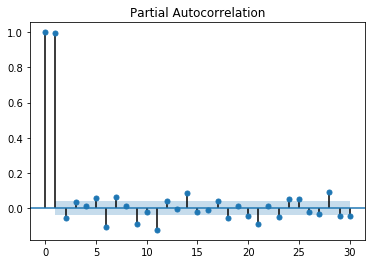

In [36]:
plot_pacf(bit.bpi, lags=30);

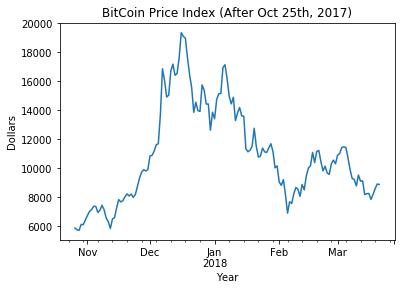

In [37]:
#
bit[bit.index>'2017-10-25']['bpi'].plot()
plt.title('BitCoin Price Index (After Oct 25th, 2017)')
plt.ylabel('Dollars')
plt.xlabel('Year');

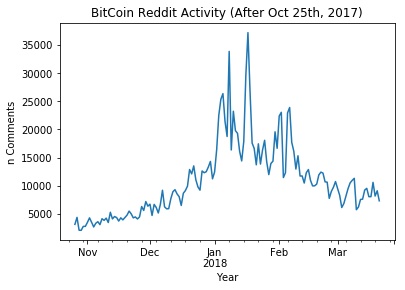

In [40]:
bit[bit.index>'2017-10-25']['comments'].plot()
plt.title('BitCoin Reddit Activity (After Oct 25th, 2017)')
plt.ylabel('n Comments')
plt.xlabel('Year');

## Trend, Seasonality & Trend

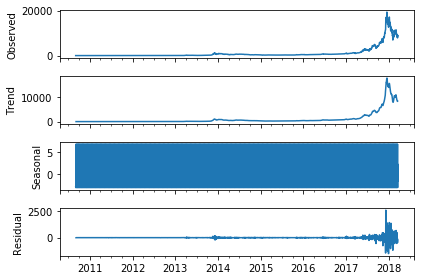

In [42]:
result = seasonal_decompose(bit.bpi)
result.plot();

Well that looks like a mess, likely due to the amount of time when bitcoin was worthless

Lets look at it when bitcoin became a bit more relivant

In [43]:
relivant  = bit[bit.index>'2016-10-27']['bpi']

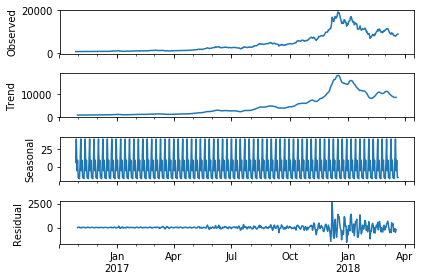

In [44]:
result = seasonal_decompose(relivant)
result.plot();

That looks better, but still a lot of dead time

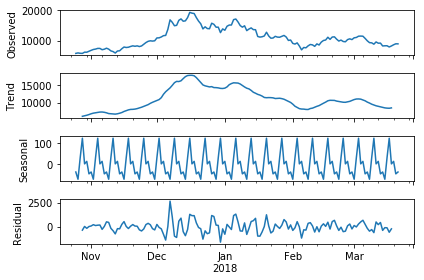

In [45]:
more_rel = bit[bit.index>='2017-10-25']['bpi']
seasonal_decompose(more_rel).plot();

Much better, well now we can see some clearer trends.

This shows us:
    - a clearer trend over time peaking in late Dec
    - Bitcoin does not seem to be heavily affected by seasonality, only +/- 100
    - Residuals seem to make up the majority of variablity, which makes sense consider how  bitcoins have stronger social driving facters rather than seasonal/global

Looking for other predictors of Bitcoin Value:
    - I am curious to see if reddit's cryptocurrency subreddit may be a predictor.

In [55]:
bit = bit[bit.index>='2017-10-25']

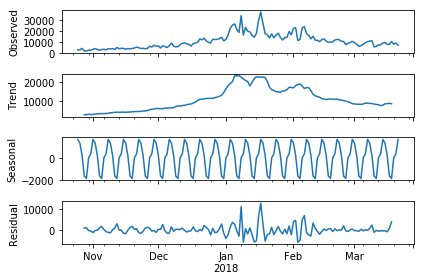

In [56]:
seasonal_decompose(bit.comments).plot();

It looks like the comments are much more affected by seasonality, than the coin's value, however +/- 2000 is still not very much when compared to the noise of 10,000

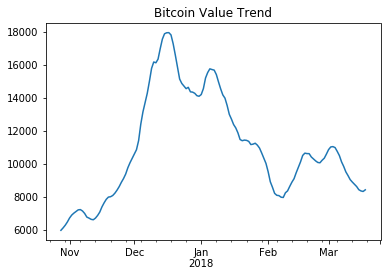

In [168]:
seasonal_decompose(more_rel).trend.plot()
plt.title('Bitcoin Value Trend');

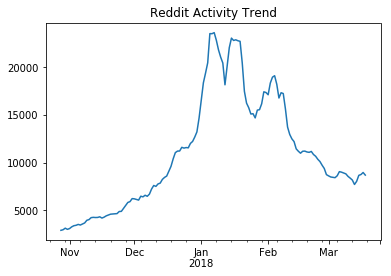

In [62]:
seasonal_decompose(bit.comments).trend.plot()
plt.title('Reddit Activity Trend');

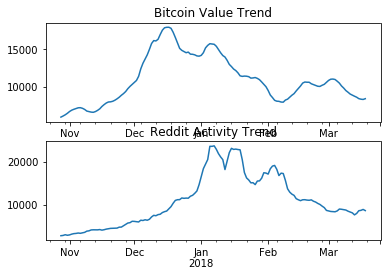

In [173]:
plt.subplot(211)
seasonal_decompose(more_rel).trend.plot()
plt.title('Bitcoin Value Trend')
plt.subplot(212)
seasonal_decompose(bit.comments).trend.plot()
plt.title('Reddit Activity Trend');

## LSTM RNN

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

In [83]:
train = more_rel[more_rel.index<'2018-02-01']
test = more_rel[more_rel.index>='2018-02-01']

In [84]:
#NN need values between 0-1
mm = MinMaxScaler()

#preprocessing
#mm scaler needs atleast a 2D array
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

#here we are predicting Q days ahead
Q = 7
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

#RNN again, needs reshaping
#the shaping choices were picked for if I want to use a multi-dim training
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [85]:
def model(X_train, y_train, dropout= 0.1, batch_size = 16, lstm_units = 7, activation = 'linear'):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units = lstm_units, activation = activation, input_shape = (None, 1)))
    regressor.add(Dropout(dropout))
    
    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mae')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = batch_size, epochs = 100)
    return(regressor)

In [86]:
regressor = model(X_train,y_train)

Epoch 1/100
92/92 [==============================] - 2s 26ms/step - loss: 0.4353
Epoch 2/100
92/92 [==============================] - 0s 502us/step - loss: 0.4222
Epoch 3/100
92/92 [==============================] - 0s 593us/step - loss: 0.4124
Epoch 4/100
92/92 [==============================] - 0s 448us/step - loss: 0.3963
Epoch 5/100
92/92 [==============================] - 0s 587us/step - loss: 0.3868
Epoch 6/100
92/92 [==============================] - 0s 541us/step - loss: 0.3703
Epoch 7/100
92/92 [==============================] - 0s 443us/step - loss: 0.3581
Epoch 8/100
92/92 [==============================] - 0s 552us/step - loss: 0.3490
Epoch 9/100
92/92 [==============================] - 0s 502us/step - loss: 0.3318
Epoch 10/100
92/92 [==============================] - 0s 519us/step - loss: 0.3203
Epoch 11/100
92/92 [==============================] - 0s 515us/step - loss: 0.3112
Epoch 12/100
92/92 [==============================] - 0s 683us/step - loss: 0.2993
Epoch 13/100
9

92/92 [==============================] - 0s 436us/step - loss: 0.1333
Epoch 100/100
92/92 [==============================] - 0s 431us/step - loss: 0.1332


In [87]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

#reshaped for NN
val = np.reshape(val, (len(val), 1, 1))
predicted_BTC_price = regressor.predict(val)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

In [88]:
pred = pd.DataFrame({'True':test_set,'Pred':predicted_BTC_price},index=test.index)

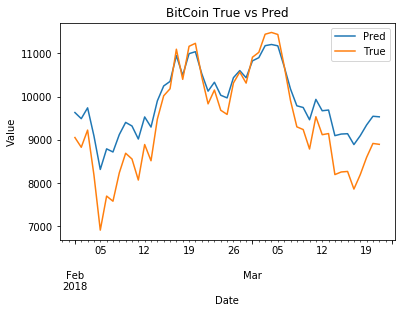

In [89]:
pred.plot()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

- This likely tells us that for the most part the NN assumes the value of bitcoin will remain more stable than it usually does (considering bitcoin's volitile nature)
- This can be remedied by:
    - Increasing the # of feature by which it is calculating the values
    - Adjust the memory that the NN fetchs from in the LSTM cells
    - Train more
        - the fear with that comes from overfitting to pre-existing trends which would ultimately do no more than say 'the score is basically yesterday's score'

## ARIMA

Lets go back to more traditional forcasting models

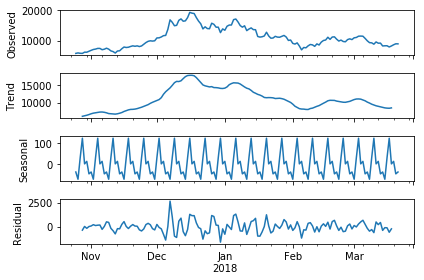

In [100]:
season = seasonal_decompose(more_rel)
season.plot();

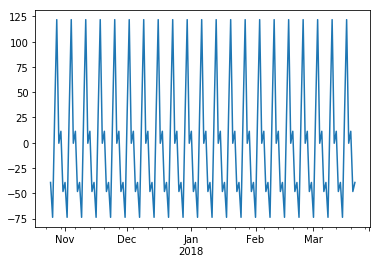

In [101]:
#It looks like the variation may align with weeks
#it would be interesting to see what days have more activity, and see how activity relates to value
season.seasonal.plot();

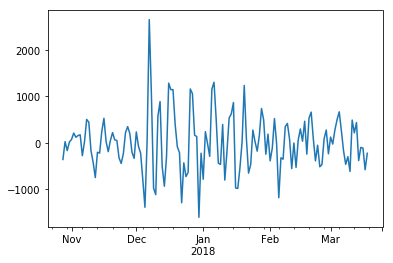

In [102]:
#Again huge imact
#It would be interesting to scrape the news/twitter/reddit 
#for what may have been a predictor for any underlying trends in these residuals
season.resid.plot();

In [103]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

### Seasonal Difference

In [104]:
#so reminder this is our data
bit.head()

,bpi,diff,comments
2017-10-25,5733.9038,215.0538,3076.0
2017-10-26,5888.1450,154.2412,3146.0
2017-10-27,5767.6800,-120.4650,4388.0
2017-10-28,5732.8250,-34.8550,2108.0
2017-10-29,6140.5313,407.7063,2089.0


In [105]:
#remember we are paying attention to when bitcoin was relivant, 'more_rel' is a numpy array
#more_rel = bit[bit.index>='2017-10-25']

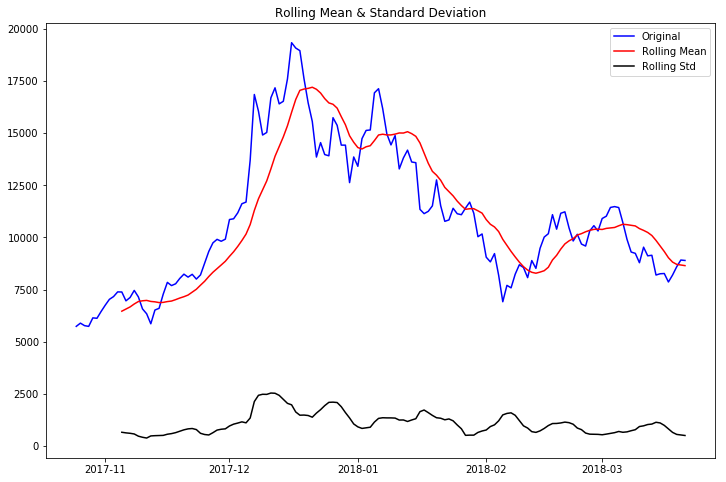

Results of Dickey-Fuller Test:
Test Statistic   -1.754336
p-value           0.403357
dtype: float64


In [131]:
#let us check and see how stationary the data is, so we can gather what we can from it
test_stationarity(bit['bpi'])

Unsurprising, the values alone are NOT stationary, because it hasn't be adjusted for

Let us look at the differences by the day

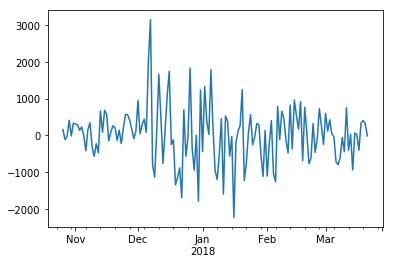

In [135]:
bit['bpi'].diff(1).plot();

Let us check how stationary the data is

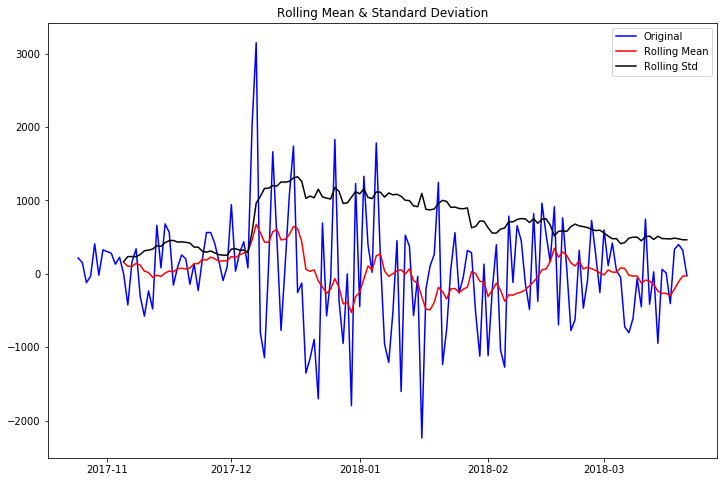

Results of Dickey-Fuller Test:
Test Statistic   -1.096526e+01
p-value           8.134015e-20
dtype: float64


In [147]:
test_stationarity(bit['diff'])

Well those map VERY heavily, because its the constant difference to the last value, so yeah it appears that the differences are stationary but that doesnt mean too much

Does finding the difference by the season AS well as the day improve things?

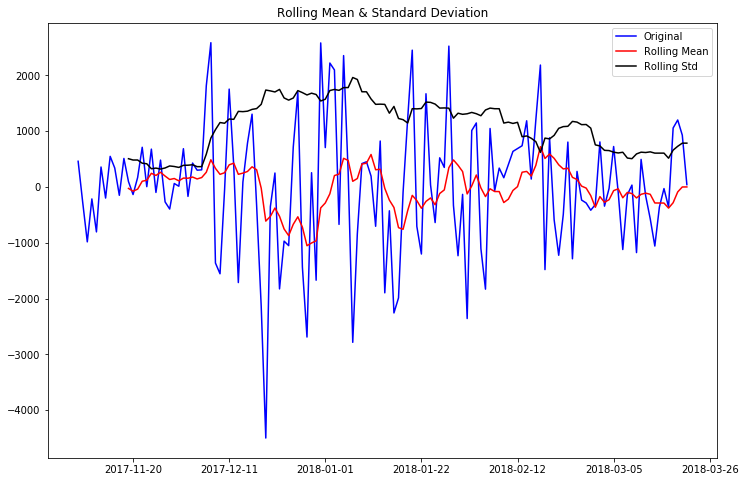

Results of Dickey-Fuller Test:
Test Statistic   -4.809367
p-value           0.000052
dtype: float64


In [136]:
#.diff(1) = diff by the day
#.diff(12) = diff by the months in year

test_stationarity(bit['bpi'].diff(1).diff(12).dropna())

Not dramatically

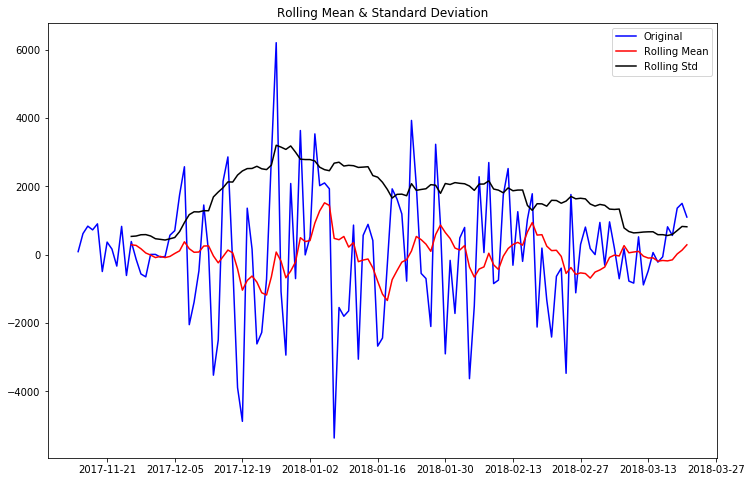

Results of Dickey-Fuller Test:
Test Statistic   -7.004180e+00
p-value           7.192888e-10
dtype: float64


In [138]:
#by day   - diff(1)
#by week  - diff(7)
#by month - diff(12)

test_stationarity(bit['bpi'].diff(1).diff(7).diff(12).dropna())

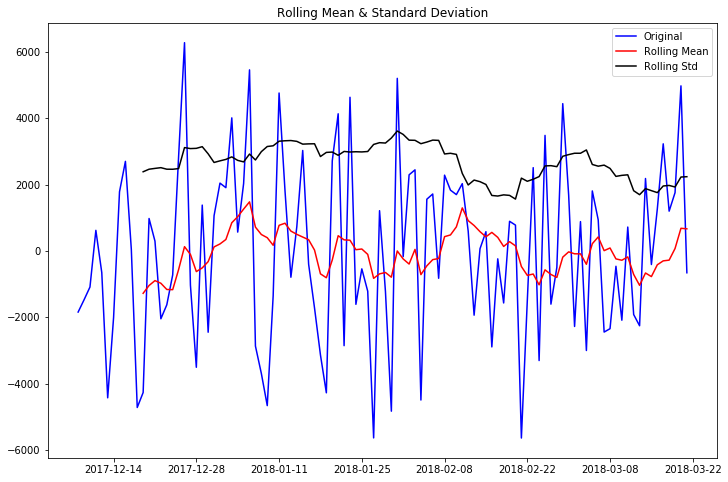

Results of Dickey-Fuller Test:
Test Statistic   -4.473813
p-value           0.000219
dtype: float64


In [142]:
#by day   - diff(1)
#by week  - diff(7)
#by month - diff(12)
#by hour  - diff(24)

#there are no more real valid ways to seperate, 
#this is not particularly useful because the values are so decomposed. 
#so this is purly for experimental purposes

test_stationarity(bit['bpi'].diff(1).diff(24).diff(7).diff(12).dropna())

In [124]:
rr = rel['bpi'].diff(1).diff(7).diff(12).dropna()

In [150]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

train_2 =  rr.head(len(rr)-21)
test_2 = rr.tail(21)

model = ARMA(train_2, (2,1)).fit()
model.summary()

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    bpi   No. Observations:                  106
Model:                     ARMA(2, 1)   Log Likelihood                -950.031
Method:                       css-mle   S.D. of innovations           1887.785
Date:                Wed, 28 Mar 2018   AIC                           1910.063
Time:                        14:42:40   BIC                           1923.380
Sample:                    11-15-2017   HQIC                          1915.460
                         - 02-28-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9681    173.627     -0.011      0.991    -342.270     338.334
ar.L1.bpi      0.2899      0.345      0.839      0.403      -0.387       0.967
ar.L2.bpi     -0.2112      0.101     -2.087      0.039      -0.410      -0.013
ma.L1.bpi     -0.1301      0.347     -0.375      0.709      -0.810       0.550
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6863           -2.0649j            2.1760           -0.1989
AR.2            0.6863           +2.0649j            2.1760            0.1989
MA.1            7.6879           +0.0000j            7.6879            0.0000
-----------------------------------------------------------------------------
"""

- Wow that model did not do well

- Lets see if we can find something better with a gridsearch
    - there will be a lot of impossible combinations, hense the 'try' params

In [151]:
arima_parameters = {"d":[0,1,2,3,4,5,6,7],
                    "p":[0,1,2,3,4,5,6,7],
                    "q":[0,1,2,3,4,5,6,7]}

In [152]:
from tqdm import tqdm

In [153]:
aic_0 = {}
for d in tqdm(arima_parameters['d']):
    for p in tqdm(arima_parameters['p']):
        for q in arima_parameters['q']:
            try:
                AR2MA = ARIMA(train_2, (p,d,q)).fit();
                params = str('|d:{}|p:{}|q:{}|'.format(d,p,q));
                aic_0[params] = AR2MA.aic;
            except:
                continue

  0%|          | 0/8 [00:00<?, ?it/s]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: I

/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|          | 0/8 [00:00<?, ?it/s]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|██▌       | 2/8 [00:02<00:08,  1.34s/it]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:654: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]

 38%|███▊      | 3/8 [00:06<00:10,  2.19s/it]/Users/Nahel/anaconda3/envs/NN/lib/python3.6/site-pa

In [154]:
aic_0

{'|d:0|p:0|q:0|': 1910.3153478523225,
 '|d:0|p:0|q:1|': 1909.177011811332,
 '|d:0|p:0|q:2|': 1907.4177493794823,
 '|d:0|p:0|q:3|': 1909.3648359825738,
 '|d:0|p:0|q:4|': 1891.1892979623576,
 '|d:0|p:0|q:5|': nan,
 '|d:0|p:0|q:7|': nan,
 '|d:0|p:1|q:0|': 1910.265500123313,
 '|d:0|p:1|q:2|': 1909.3045671964508,
 '|d:0|p:1|q:4|': 1892.7028690156721,
 '|d:0|p:1|q:5|': 1891.5955555738662,
 '|d:0|p:1|q:6|': 1879.753520460204,
 '|d:0|p:2|q:0|': 1908.1743653843207,
 '|d:0|p:2|q:1|': 1910.0626153909461,
 '|d:0|p:2|q:2|': 1888.494041960907,
 '|d:0|p:2|q:3|': 1887.9488029462552,
 '|d:0|p:2|q:4|': 1878.0491879585234,
 '|d:0|p:2|q:6|': 1871.7961648781481,
 '|d:0|p:3|q:0|': 1910.041070467519,
 '|d:0|p:3|q:1|': 1912.0359361573057,
 '|d:0|p:3|q:2|': 1888.1526954299459,
 '|d:0|p:3|q:3|': nan,
 '|d:0|p:4|q:0|': 1911.9271619450174,
 '|d:0|p:4|q:1|': 1910.0983835264342,
 '|d:0|p:4|q:2|': 1889.0366204527327,
 '|d:0|p:4|q:3|': nan,
 '|d:0|p:4|q:4|': 1869.9787288084822,
 '|d:0|p:5|q:0|': 1896.064652728996,
 '

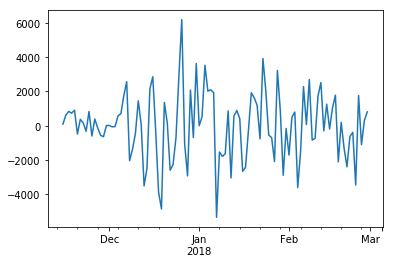

In [155]:
train_2.plot()

In [263]:
by_weekday

Mon      229091.9941
Tues     228578.7714
Wed      229041.4141
Thurs    225637.9243
Fri      227920.9004
Sat      230462.4043
Sun      228344.7632
Name: bpi, dtype: float64

In [277]:
import seaborn as sns

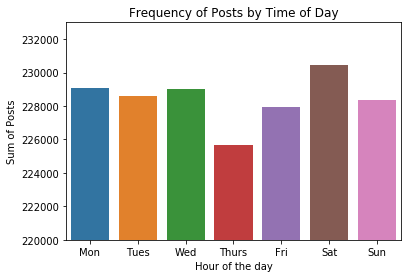

In [290]:
ax = sns.barplot(x=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
            y=rel.bpi.groupby(rel.index.dayofweek).sum())
ax.set_title('Frequency of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');
plt.ylim(220000, 233000);